In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成 y = wx + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成形状为 (num_examples, len(w)) 的张量X，每列是从均值为0、标准差为1的正态分布中随机采样num_examples个点
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabels:', labels[0])


features: tensor([-0.8019, -0.8980]) 
labels: tensor([5.6399])


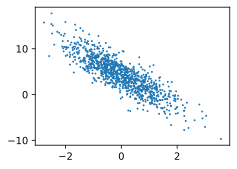

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1);  
# detach用于将张量从计算图中分离（不需要梯度的时候使用）；1表示点的半径大小

In [ ]:
# 小批量读取数据集（用于在GPU上并行计算）
def data_iter(batch_size, features, labels):
    num_examples = len(features)
     # 随机读取样本
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 【生成器】yield在函数中返回一个值，并暂停函数的执行，直到下一次调用生成器的时候再继续执行

In [13]:
# 感受一下小批量运算
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7021, -0.6030],
        [ 1.0386,  0.8637],
        [-1.2085,  0.8587],
        [-0.9389,  1.7166],
        [-0.0813,  0.8972],
        [-1.3214, -0.5579],
        [ 0.7361, -2.1606],
        [ 0.7858, -1.0662],
        [-0.5632,  0.1907],
        [ 0.3489, -2.4797]]) 
 tensor([[ 4.8417],
        [ 3.3488],
        [-1.1374],
        [-3.4965],
        [ 1.0027],
        [ 3.4615],
        [13.0292],
        [ 9.3874],
        [ 2.4194],
        [13.3246]])


上述代码用于迭代的教学很好，但是它的执行效率很低，例如，它**要求我们将所有数据加载到内存中，并执行大量的随机内存访问**。
在深度学习框架中实现的内置迭代器效率要高得多，它可以处理**存储在文件中的数据和数据流提供的数据**。

In [15]:
# 定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [16]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():  # 这里不是特别明白为什么要加这句话
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()   # 自定义代码使用，一般用param.zero_grad()

## 训练

In [37]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [ ]:
# 定义超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10
# batch_size = 30

# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()  # 这里什么时候是l.sum(), 什么时候是l.mean()，分别有什么意义  # 哦~在sgd里面梯度除以batch_size了！
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000126
epoch 2, loss 0.000046
epoch 3, loss 0.000046


### test 1: l.sum() 改成 l.mean()


In [39]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [40]:
# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.mean().backward()  # 这个例子中，应该是sum的时候梯度较大，更新较快，较快收敛
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 15.609968
epoch 2, loss 14.570199
epoch 3, loss 13.606002


### test 2: 要30个epoch才能到原来的效果（10倍），刚好batch_size = 10？确实线性，用batch_size=30又验证了一下

In [50]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [51]:
num_epochs = 90
# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.mean().backward()  # 这个例子中，应该是sum的时候梯度较大，更新较快，较快收敛
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 15.706339
epoch 2, loss 14.659874
epoch 3, loss 13.690228
epoch 4, loss 12.787216
epoch 5, loss 11.940008
epoch 6, loss 11.139398
epoch 7, loss 10.402186
epoch 8, loss 9.710739
epoch 9, loss 9.064618
epoch 10, loss 8.459512
epoch 11, loss 7.900909
epoch 12, loss 7.378621
epoch 13, loss 6.891159
epoch 14, loss 6.435296
epoch 15, loss 6.007089
epoch 16, loss 5.607176
epoch 17, loss 5.235066
epoch 18, loss 4.891416
epoch 19, loss 4.567880
epoch 20, loss 4.264334
epoch 21, loss 3.980073
epoch 22, loss 3.715068
epoch 23, loss 3.469148
epoch 24, loss 3.241913
epoch 25, loss 3.026664
epoch 26, loss 2.825200
epoch 27, loss 2.638395
epoch 28, loss 2.464087
epoch 29, loss 2.299836
epoch 30, loss 2.147767
epoch 31, loss 2.005089
epoch 32, loss 1.871543
epoch 33, loss 1.747436
epoch 34, loss 1.632194
epoch 35, loss 1.523852
epoch 36, loss 1.422907
epoch 37, loss 1.328742
epoch 38, loss 1.240992
epoch 39, loss 1.158885
epoch 40, loss 1.081883
epoch 41, loss 1.010862
epoch 42, loss 0.9

In [55]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差；{true_b - b}')

w的估计误差：tensor([-0.0002, -0.0009], grad_fn=<SubBackward0>)
b的估计误差；tensor([-0.0003], grad_fn=<RsubBackward1>)
